In [ ]:
import pandas as pd
import pytz
from datetime import datetime
import numpy as np

## Unknown

In [ ]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

In [ ]:
known_feature = X_test.copy()
known_lanels = y_test.copy()

## Unknown Class

In [ ]:
df = pd.read_csv('data_5773.csv') # data.csv is a dataset csv file having total six column: md5, TTP, timestamp, group, Aliases, Country
df

In [ ]:
def convert_to_timezone(row):
    # country = row['Country']
    time_str = row['timestamp']

    # Attempt to parse the datetime string
    try:
        utc_time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S UTC')
        utc_time = utc_time.replace(tzinfo=pytz.UTC)
        return utc_time.strftime('%H:%M:%S')
    except ValueError:
        # print(time_str)
        # If there's an error in parsing, return a placeholder
        return 'Invalid Timestamp'

df['utc_time'] = df.apply(convert_to_timezone, axis=1)

In [ ]:
label_counts = df["group"].value_counts()
filtered_labels = label_counts[label_counts < 30].index.tolist()

filtered_df = df.copy() # Comment this if not filtering based on count

# Filter the DataFrame to include only rows with filtered labels
filtered_df = df[df["group"].isin(filtered_labels)]
len(filtered_df["group"].value_counts()), filtered_df.shape, filtered_df["group"].value_counts()

(125,
 (762, 9),
 group
 Northern Fox     29
 APT19            29
 Mofang           27
 GreyEnergy       25
 Evilnum          24
                  ..
 TurkHackTeam      1
 Red Signature     1
 Scarlet Mimic     1
 Confucius         1
 MM CORE           1
 Name: count, Length: 125, dtype: int64)

In [ ]:
#eval(filtered_df["TTP"][0])
ttp = []
for i in list(filtered_df["TTP"]):
    ttp.append(eval(i))

#Target labels
labels = filtered_df["group"]

len(ttp),ttp[0]

(762,
 ['T1087',
  'T1614',
  'T1083',
  'T1033',
  'T1010',
  'T1082',
  'T1012',
  'T1129',
  'T1497'])

## Feature

In [ ]:
df = filtered_df.copy()
# Extract hours from 'local_24hr_time'
df['hour'] = df['utc_time'].apply(lambda x: int(x.split(':')[0]) if x != 'Invalid Timestamp' and x != 'Country Unrecognized or Error' else -1)
# Filter out any rows where time conversion was unsuccessful
df = df[df['hour'] != -1]
df['minute'] = df['utc_time'].apply(lambda x: int(x.split(':')[1]))
df['second'] = df['utc_time'].apply(lambda x: int(x.split(':')[2]))

### Sin Cos

In [ ]:
# Convert hours, minutes, and seconds to cyclical features
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['minute_sin'] = np.sin(2 * np.pi * df['minute']/60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute']/60)
df['second_sin'] = np.sin(2 * np.pi * df['second']/60)
df['second_cos'] = np.cos(2 * np.pi * df['second']/60)

In [ ]:
filtered_df = df.copy()

### OneHot

In [ ]:
filtered_df["group"]

278      Cobalt Group
279      Cobalt Group
280      Cobalt Group
281      Cobalt Group
282      Cobalt Group
            ...      
5762    Sandworm Team
5764          Strider
5765            APT12
5766          Silence
5767          Silence
Name: group, Length: 751, dtype: object

In [ ]:
#eval(filtered_df["TTP"][0])
ttp = []
for i in list(filtered_df["TTP"]):
    ttp.append(eval(i))

#Target labels
labels = filtered_df["group"]

In [ ]:
# Create a set of unique categories from all the lists
unique_categories = set(category for categories in ttp for category in categories)

df_one_hot = filtered_df.copy()

# Create binary columns for each unique category
for category in unique_categories:
    df_one_hot[category] = filtered_df['TTP'].apply(lambda x: 1 if category in x else 0)

# Drop the original 'feature_list' column
df_one_hot.drop('TTP', axis=1, inplace=True)

In [ ]:
df_one_hot_feature = df_one_hot.drop(columns=["md5","group","Aliases","Country",'timestamp', 'utc_time', 'hour', 'minute', 'second','hour_sin','hour_cos','minute_sin','minute_cos','second_sin','second_cos'])
labels = df_one_hot["group"]
len(df_one_hot_feature), len(labels), df_one_hot_feature, labels

(751,
 751,
       T1069  T1115  T1105  T1055  T1027  T1098  T1112  T1490  T1529  T1518  \
 278       0      0      0      0      0      0      0      0      0      0   
 279       0      0      0      0      1      0      0      0      0      0   
 280       0      0      0      0      0      0      0      0      0      0   
 281       0      0      0      0      0      0      0      0      0      0   
 282       0      0      0      0      1      0      0      0      0      0   
 ...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
 5762      0      0      0      0      0      0      0      0      0      0   
 5764      0      0      0      0      1      0      0      0      0      0   
 5765      0      0      0      0      1      0      0      0      0      0   
 5766      0      0      0      1      0      0      0      0      0      1   
 5767      0      0      0      0      0      0      0      0      0      0   
 
       ...  T1555  T1135  T1620  T1482

### TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(filtered_df['TTP'].apply(lambda x: ''.join(x)))


# Convert to a DataFrame
df_tfidf_vector = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
# print(df_tfidf_vector.shape)
# Concatenate the vectorized features with the original DataFrame
# df_tfidf_vector = pd.concat([filtered_df, df_vectorized], axis=1)
# df_tfidf_vector["HASH"] = filtered_df["HASH"]
# df_tfidf_vector["APT Group"] = filtered_df["APT Group"]

In [ ]:
# df_tfidf_vector_feature = df_tfidf_vector.drop(columns=["HASH","APT Group"])
labels = filtered_df["group"]
len(df_tfidf_vector), len(labels)

(751, 751)

## Merged

In [ ]:
df_hr_s = df[['hour_sin']]
df_hr_c = df[['hour_cos']]
df_mn_s = df[['minute_sin']]
df_mn_c = df[['minute_cos']]
df_sc_s = df[['second_sin']]
df_sc_c = df[['second_cos']]

In [ ]:
df_one_hot_feature = df_one_hot_feature.reset_index(drop=True)
df_tfidf_vector = df_tfidf_vector.reset_index(drop=True)
df_hr_s = df_hr_s.reset_index(drop=True)
df_hr_c = df_hr_c.reset_index(drop=True)
df_mn_s = df_mn_s.reset_index(drop=True)
df_mn_c = df_mn_c.reset_index(drop=True)
df_sc_s = df_sc_s.reset_index(drop=True)
df_sc_c = df_sc_c.reset_index(drop=True)

In [ ]:
merged_feature = pd.concat([df_one_hot_feature,df_tfidf_vector,df_hr_s, df_hr_c, df_mn_s, df_mn_c, df_sc_s, df_sc_c], axis=1)
merged_feature

,T1069,T1115,T1105,T1055,T1027,T1098,T1112,T1490,T1529,T1518,...,t1564,t1569,t1614,t1620,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.406105,0.000000,-0.866025,5.000000e-01,0.000000,1.000000,-0.207912,-0.978148
1,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,-0.866025,5.000000e-01,-0.743145,0.669131,-0.207912,-0.978148
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.258819,-9.659258e-01,-0.951057,-0.309017,0.309017,-0.951057
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.500000,-8.660254e-01,0.406737,0.913545,-0.207912,-0.978148
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.965926,-2.588190e-01,-0.104528,-0.994522,-0.913545,-0.406737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.258819,-9.659258e-01,-0.743145,-0.669131,-0.669131,0.743145
747,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.258819,9.659258e-01,0.587785,-0.809017,-0.994522,-0.104528
748,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,1.000000,6.123234e-17,-0.951057,-0.309017,-0.913545,0.406737
749,0,0,0,1,0,0,0,0,0,1,...,0.0,0.0,0.000000,0.450806,0.965926,2.588190e-01,0.587785,0.809017,-0.978148,0.207912


In [ ]:
unknown_feature = merged_feature.copy()
unknown_labels = ["Unknown"]*unknown_feature.shape[0]

In [ ]:
unknown_feature["group"]=[0]*unknown_feature.shape[0]
known_feature["group"]=[1]*known_feature.shape[0]

In [ ]:
unknown_feature

,T1069,T1115,T1105,T1055,T1027,T1098,T1112,T1490,T1529,T1518,...,t1569,t1614,t1620,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,group
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.406105,0.000000,-0.866025,5.000000e-01,0.000000,1.000000,-0.207912,-0.978148,0
1,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.000000,-0.866025,5.000000e-01,-0.743145,0.669131,-0.207912,-0.978148,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.258819,-9.659258e-01,-0.951057,-0.309017,0.309017,-0.951057,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.500000,-8.660254e-01,0.406737,0.913545,-0.207912,-0.978148,0
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.000000,0.965926,-2.588190e-01,-0.104528,-0.994522,-0.913545,-0.406737,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0,0,0,0,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.258819,-9.659258e-01,-0.743145,-0.669131,-0.669131,0.743145,0
747,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.000000,0.258819,9.659258e-01,0.587785,-0.809017,-0.994522,-0.104528,0
748,0,0,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.000000,1.000000,6.123234e-17,-0.951057,-0.309017,-0.913545,0.406737,0
749,0,0,0,1,0,0,0,0,0,1,...,0.0,0.000000,0.450806,0.965926,2.588190e-01,0.587785,0.809017,-0.978148,0.207912,0


In [ ]:
known_feature

,T1564,T1082,T1033,T1083,T1007,T1027,T1529,T1518,T1055,T1222,...,t1569,t1614,t1620,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,group
0,0,0,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.707107,-7.071068e-01,0.500000,-8.660254e-01,-0.104528,-0.994522,1
1,0,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.707107,7.071068e-01,0.743145,6.691306e-01,-0.951057,0.309017,1
2,0,1,1,1,1,1,0,1,0,0,...,0.0,0.0,0.0,0.000000,1.000000e+00,-0.500000,-8.660254e-01,0.978148,0.207912,1
3,0,1,1,1,1,0,0,1,0,0,...,0.0,0.0,0.0,1.000000,6.123234e-17,-0.809017,5.877853e-01,0.809017,0.587785,1
4,0,1,0,1,0,1,0,0,1,0,...,0.0,0.0,0.0,-0.500000,-8.660254e-01,0.406737,9.135455e-01,-0.913545,0.406737,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,-0.500000,8.660254e-01,0.978148,-2.079117e-01,-0.743145,0.669131,1
997,0,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,-0.258819,-9.659258e-01,-0.500000,8.660254e-01,0.866025,-0.500000,1
998,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,-1.000000,-1.836970e-16,0.743145,-6.691306e-01,-0.406737,0.913545,1
999,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.965926,-2.588190e-01,-1.000000,-1.836970e-16,0.743145,-0.669131,1


In [ ]:
import pandas as pd

# Assuming df1 and df2 are your dataframes
common_columns = known_feature.columns.tolist()
unknown_feature = unknown_feature.reindex(columns=common_columns, fill_value=0)

merged_df = pd.concat([known_feature, unknown_feature], axis=0)
merged_df

,T1564,T1082,T1033,T1083,T1007,T1027,T1529,T1518,T1055,T1222,...,t1569,t1614,t1620,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,group
0,0,0,0,1,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.707107,-7.071068e-01,0.500000,-0.866025,-0.104528,-0.994522,1
1,0,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.000000,0.707107,7.071068e-01,0.743145,0.669131,-0.951057,0.309017,1
2,0,1,1,1,1,1,0,1,0,0,...,0.0,0.0,0.000000,0.000000,1.000000e+00,-0.500000,-0.866025,0.978148,0.207912,1
3,0,1,1,1,1,0,0,1,0,0,...,0.0,0.0,0.000000,1.000000,6.123234e-17,-0.809017,0.587785,0.809017,0.587785,1
4,0,1,0,1,0,1,0,0,1,0,...,0.0,0.0,0.000000,-0.500000,-8.660254e-01,0.406737,0.913545,-0.913545,0.406737,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.258819,-9.659258e-01,-0.743145,-0.669131,-0.669131,0.743145,0
747,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.258819,9.659258e-01,0.587785,-0.809017,-0.994522,-0.104528,0
748,0,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.000000,1.000000,6.123234e-17,-0.951057,-0.309017,-0.913545,0.406737,0
749,0,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.450806,0.965926,2.588190e-01,0.587785,0.809017,-0.978148,0.207912,0


In [ ]:
merged_df.to_csv("KNOW_UNKNOW_MERGED_TEST_SET.csv",index=False)

## Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support


def rf(X_train, X_test, y_train, y_test):
  # # Load your dataset and split it into training and testing sets
  # X_train, X_test, y_train, y_test = train_test_split(df_one_hot_feature, labels, test_size=0.2, random_state=42, stratify=labels)

  # Create a Random Forest model with a specified number of trees
  # model = RandomForestClassifier(n_estimators=100,random_state=42)  # You can change the number of trees
  model = RandomForestClassifier(max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)

  # Train the model on the training data
  model.fit(X_train, y_train)

  # Make predictions on the test data
  y_pred = model.predict(X_test)

  # Evaluate the model
  rf_accuracy = accuracy_score(y_test, y_pred)
  rf_f1 = f1_score(y_test, y_pred, average='macro')
  rf_pre = precision_score(y_test, y_pred, average='macro')
  rf_rec = recall_score(y_test, y_pred, average='macro')

  # Precision group-wise
  rf_grp_prec, rf_grp_rec, rf_grp_f1, _  = precision_recall_fscore_support(y_test, y_pred, average=None)

  return rf_accuracy, rf_pre, rf_rec, rf_f1, rf_grp_prec, rf_grp_rec, rf_grp_f1, model

In [ ]:
rf_accuracy, rf_pre, rf_rec, rf_f1, rf_grp_prec, rf_grp_rec, rf_grp_f1, model = rf(X_train, X_test, y_train, y_test)

In [ ]:
known_feature[known_feature['group'] == '1']
known_feature = known_feature.drop('group',axis=1)
known_feature

,T1564,T1082,T1033,T1083,T1007,T1027,T1529,T1518,T1055,T1222,...,t1564,t1569,t1614,t1620,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,0,0,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.707107,-7.071068e-01,0.500000,-8.660254e-01,-0.104528,-0.994522
1,0,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.707107,7.071068e-01,0.743145,6.691306e-01,-0.951057,0.309017
2,0,1,1,1,1,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.000000,1.000000e+00,-0.500000,-8.660254e-01,0.978148,0.207912
3,0,1,1,1,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.000000,6.123234e-17,-0.809017,5.877853e-01,0.809017,0.587785
4,0,1,0,1,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,-0.500000,-8.660254e-01,0.406737,9.135455e-01,-0.913545,0.406737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,-0.500000,8.660254e-01,0.978148,-2.079117e-01,-0.743145,0.669131
997,0,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,-0.258819,-9.659258e-01,-0.500000,8.660254e-01,0.866025,-0.500000
998,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,-1.000000,-1.836970e-16,0.743145,-6.691306e-01,-0.406737,0.913545
999,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.965926,-2.588190e-01,-1.000000,-1.836970e-16,0.743145,-0.669131


In [ ]:
# Assuming 'model' is your trained multi-class classification model
probs_known = model.predict_proba(known_feature)
probs_known

array([[0.00000000e+00, 5.66666667e-02, 7.03333333e-01, ...,
        0.00000000e+00, 3.33333333e-03, 3.33333333e-03],
       [0.00000000e+00, 1.66666667e-02, 0.00000000e+00, ...,
        3.33333333e-03, 8.96666667e-01, 0.00000000e+00],
       [0.00000000e+00, 9.70000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.66666667e-03, 3.66666667e-02, ...,
        0.00000000e+00, 9.33333333e-02, 4.66666667e-02],
       [8.33333333e-04, 3.33333333e-03, 2.91666667e-02, ...,
        2.00000000e-02, 1.66666667e-02, 0.00000000e+00]])

In [ ]:
y_test, probs_known.shape

(          group
 0         APT32
 1         Turla
 2          APT1
 3          APT1
 4     Dragonfly
 ...         ...
 996       APT32
 997       APT32
 998       TA505
 999    menuPass
 1000   Lamberts
 
 [1001 rows x 1 columns],
 (1001, 27))

In [ ]:
encoded_labels=model.classes_
encoded_labels

array(['APT-Q-20', 'APT1', 'APT17', 'APT21', 'APT28', 'APT29', 'APT3',
       'APT30', 'APT32', 'Cleaver', 'DarkHotel', 'Dragonfly', 'Equation',
       'Gorgon Group', 'Hades', 'Hellsing', 'IceFog', 'Ke3chang',
       'Lamberts', 'Lazarus Group', 'PROMETHIUM', 'PatchWork', 'TA505',
       'Thrip', 'Transparent Tribe', 'Turla', 'menuPass'], dtype=object)

### Threshold-Precision

In [ ]:
from sklearn.metrics import precision_score
import numpy as np

# Assuming your_model is your trained classifier and X_test is your test data
probabilities = model.predict_proba(X_test)

# Range of thresholds to test
# thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# Create a list of each possible two-decimal digit number between 0 and 1
thresholds = [round(i * 0.01, 2) for i in range(101)]



precision_list = []

best_threshold = 0
best_precision = 0

for threshold in thresholds:
    # Apply threshold
    predictions = np.max(probabilities, axis=1) > threshold # predictions is a boolean array where each element is True if the highest probability for a sample exceeds the threshold, and False otherwise.
    mapped_labels = np.argmax(probabilities, axis=1) * predictions
    y_pred = encoded_labels[mapped_labels]
    # print(y_pred)


    # Calculate precision
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_list.append(round(precision,4)*100)

    if precision > best_precision:
        best_precision = precision
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}")
print(f"Best Precision: {best_precision}")


Best Threshold: 0.61
Best Precision: 0.9201714683120102


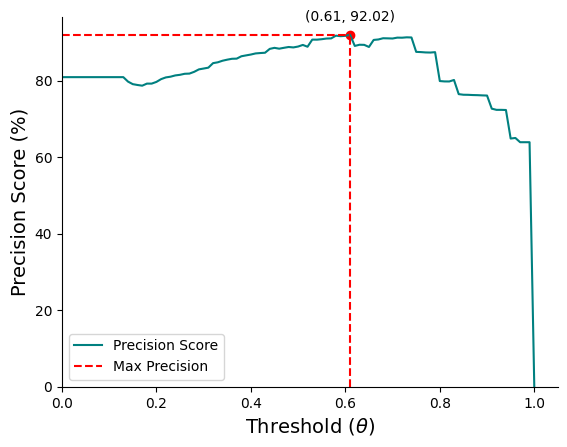

In [ ]:
import matplotlib.pyplot as plt

# Example data
threshold = thresholds  # Replace with your threshold values
score = precision_list  # Replace with your score values

# Find the index of the highest score
max_score_index = score.index(max(score))
max_threshold = threshold[max_score_index]
max_score = score[max_score_index]

# Plotting the graph
plt.plot(threshold, score, label='Precision Score', color="Teal")

# Highlight the highest point
plt.scatter(max_threshold, max_score, color='red', marker='o')
plt.plot([max_threshold, max_threshold], [0, max_score], 'r--', label='Max Precision')
plt.plot([0, max_threshold], [max_score, max_score], 'r--')

# Annotate the highest point with coordinates
plt.annotate(f'({max_threshold}, {max_score})', (max_threshold, max_score), textcoords="offset points", xytext=(0,10), ha='center')

# Adding labels and title
plt.xlabel(r'Threshold ($\theta$)', fontsize=14)
plt.ylabel('Precision Score (%)', fontsize=14)
# plt.title('Score vs. Threshold')
plt.legend()

# Adjusting the axes to start from 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Removing the top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig("Threshold_Precision.pdf")

# Show the plot
plt.show()


## Random Forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support


def rf(X_train, X_test, y_train, y_test):
  # # Load your dataset and split it into training and testing sets
  # X_train, X_test, y_train, y_test = train_test_split(df_one_hot_feature, labels, test_size=0.2, random_state=42, stratify=labels)

  # Create a Random Forest model with a specified number of trees
  # model = RandomForestClassifier(n_estimators=100,random_state=42)  # You can change the number of trees
  model = RandomForestClassifier(max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42)

  # Train the model on the training data
  model.fit(X_train, y_train)

  # Make predictions on the test data
  y_pred = model.predict(X_test)

  # Evaluate the model
  rf_accuracy = accuracy_score(y_test, y_pred)
  rf_f1 = f1_score(y_test, y_pred, average='macro')
  rf_pre = precision_score(y_test, y_pred, average='macro')
  rf_rec = recall_score(y_test, y_pred, average='macro')

  # Precision group-wise
  rf_grp_prec, rf_grp_rec, rf_grp_f1, _  = precision_recall_fscore_support(y_test, y_pred, average=None)

  return rf_accuracy, rf_pre, rf_rec, rf_f1, rf_grp_prec, rf_grp_rec, rf_grp_f1, model

In [ ]:
rf_accuracy, rf_pre, rf_rec, rf_f1, rf_grp_prec, rf_grp_rec, rf_grp_f1, model = rf(X_train, X_test, y_train, y_test)
list(map(lambda x: round(x, 4)*100, [rf_accuracy, rf_pre, rf_rec, rf_f1]))

In [ ]:
known_feature[known_feature['group'] == '1']
known_feature = known_feature.drop('group',axis=1)
known_feature

,T1564,T1082,T1033,T1083,T1007,T1027,T1529,T1518,T1055,T1222,...,t1564,t1569,t1614,t1620,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,0,0,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.707107,-7.071068e-01,0.500000,-8.660254e-01,-0.104528,-0.994522
1,0,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.707107,7.071068e-01,0.743145,6.691306e-01,-0.951057,0.309017
2,0,1,1,1,1,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.000000,1.000000e+00,-0.500000,-8.660254e-01,0.978148,0.207912
3,0,1,1,1,1,0,0,1,0,0,...,0.0,0.0,0.0,0.0,1.000000,6.123234e-17,-0.809017,5.877853e-01,0.809017,0.587785
4,0,1,0,1,0,1,0,0,1,0,...,0.0,0.0,0.0,0.0,-0.500000,-8.660254e-01,0.406737,9.135455e-01,-0.913545,0.406737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,-0.500000,8.660254e-01,0.978148,-2.079117e-01,-0.743145,0.669131
997,0,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,-0.258819,-9.659258e-01,-0.500000,8.660254e-01,0.866025,-0.500000
998,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,-1.000000,-1.836970e-16,0.743145,-6.691306e-01,-0.406737,0.913545
999,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.965926,-2.588190e-01,-1.000000,-1.836970e-16,0.743145,-0.669131


In [ ]:
# Assuming 'model' is your trained multi-class classification model
probs_known = model.predict_proba(known_feature)
probs_known

array([[0.00000000e+00, 5.66666667e-02, 7.03333333e-01, ...,
        0.00000000e+00, 3.33333333e-03, 3.33333333e-03],
       [0.00000000e+00, 1.66666667e-02, 0.00000000e+00, ...,
        3.33333333e-03, 8.96666667e-01, 0.00000000e+00],
       [0.00000000e+00, 9.70000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.66666667e-03, 3.66666667e-02, ...,
        0.00000000e+00, 9.33333333e-02, 4.66666667e-02],
       [8.33333333e-04, 3.33333333e-03, 2.91666667e-02, ...,
        2.00000000e-02, 1.66666667e-02, 0.00000000e+00]])

In [ ]:
y_test, probs_known.shape

(          group
 0         APT32
 1         Turla
 2          APT1
 3          APT1
 4     Dragonfly
 ...         ...
 996       APT32
 997       APT32
 998       TA505
 999    menuPass
 1000   Lamberts
 
 [1001 rows x 1 columns],
 (1001, 27))

In [ ]:
encoded_labels=model.classes_
encoded_labels

array(['APT-Q-20', 'APT1', 'APT17', 'APT21', 'APT28', 'APT29', 'APT3',
       'APT30', 'APT32', 'Cleaver', 'DarkHotel', 'Dragonfly', 'Equation',
       'Gorgon Group', 'Hades', 'Hellsing', 'IceFog', 'Ke3chang',
       'Lamberts', 'Lazarus Group', 'PROMETHIUM', 'PatchWork', 'TA505',
       'Thrip', 'Transparent Tribe', 'Turla', 'menuPass'], dtype=object)

### Threshold-Precision

In [ ]:
from sklearn.metrics import precision_score
import numpy as np

# Assuming your_model is your trained classifier and X_test is your test data
probabilities = model.predict_proba(X_test)

# Range of thresholds to test
# thresholds = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# Create a list of each possible two-decimal digit number between 0 and 1
thresholds = [round(i * 0.01, 2) for i in range(101)]



precision_list = []

best_threshold = 0
best_precision = 0

for threshold in thresholds:
    # Apply threshold
    predictions = np.max(probabilities, axis=1) > threshold # predictions is a boolean array where each element is True if the highest probability for a sample exceeds the threshold, and False otherwise.
    mapped_labels = np.argmax(probabilities, axis=1) * predictions
    y_pred = encoded_labels[mapped_labels]
    # print(y_pred)


    # Calculate precision
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_list.append(round(precision,4)*100)

    if precision > best_precision:
        best_precision = precision
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}")
print(f"Best Precision: {best_precision}")


Best Threshold: 0.61
Best Precision: 0.9201714683120102


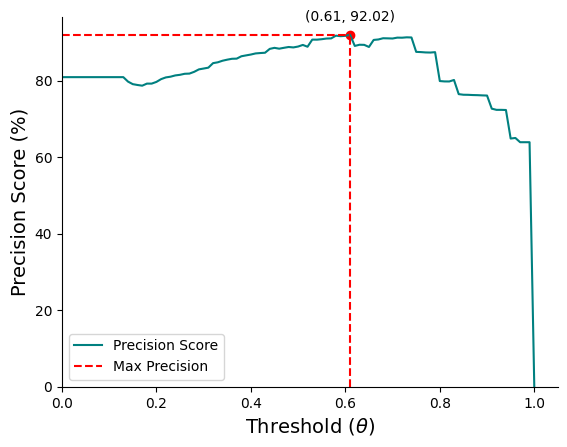

In [ ]:
import matplotlib.pyplot as plt

# Example data
threshold = thresholds  # Replace with your threshold values
score = precision_list  # Replace with your score values

# Find the index of the highest score
max_score_index = score.index(max(score))
max_threshold = threshold[max_score_index]
max_score = score[max_score_index]

# Plotting the graph
plt.plot(threshold, score, label='Precision Score', color="Teal")

# Highlight the highest point
plt.scatter(max_threshold, max_score, color='red', marker='o')
plt.plot([max_threshold, max_threshold], [0, max_score], 'r--', label='Max Precision')
plt.plot([0, max_threshold], [max_score, max_score], 'r--')

# Annotate the highest point with coordinates
plt.annotate(f'({max_threshold}, {max_score})', (max_threshold, max_score), textcoords="offset points", xytext=(0,10), ha='center')

# Adding labels and title
plt.xlabel(r'Threshold ($\theta$)', fontsize=14)
plt.ylabel('Precision Score (%)', fontsize=14)
# plt.title('Score vs. Threshold')
plt.legend()

# Adjusting the axes to start from 0
plt.xlim(left=0)
plt.ylim(bottom=0)

# Removing the top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.savefig("Threshold_Precision.pdf")

# Show the plot
plt.show()


In [ ]:
unknown_feature = unknown_feature.drop('group',axis=1)
unknown_feature

,T1564,T1082,T1033,T1083,T1007,T1027,T1529,T1518,T1055,T1222,...,t1564,t1569,t1614,t1620,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,0,1,1,1,0,0,0,0,0,0,...,0.0,0.0,0.406105,0.000000,-0.866025,5.000000e-01,0.000000,1.000000,-0.207912,-0.978148
1,0,1,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.000000,-0.866025,5.000000e-01,-0.743145,0.669131,-0.207912,-0.978148
2,0,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.258819,-9.659258e-01,-0.951057,-0.309017,0.309017,-0.951057
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.500000,-8.660254e-01,0.406737,0.913545,-0.207912,-0.978148
4,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.965926,-2.588190e-01,-0.104528,-0.994522,-0.913545,-0.406737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.258819,-9.659258e-01,-0.743145,-0.669131,-0.669131,0.743145
747,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.258819,9.659258e-01,0.587785,-0.809017,-0.994522,-0.104528
748,0,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.000000,1.000000,6.123234e-17,-0.951057,-0.309017,-0.913545,0.406737
749,0,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.000000,0.450806,0.965926,2.588190e-01,0.587785,0.809017,-0.978148,0.207912


In [ ]:
# Assuming your_model is your trained classifier and X_test is your test data
unknown_probabilities = model.predict_proba(unknown_feature)

# Apply threshold
unknow_predictions = np.max(unknown_probabilities, axis=1) < 0.61
mapped_labels = np.argmax(unknown_probabilities, axis=1) * unknow_predictions
y_pred = encoded_labels[mapped_labels]
# print(y_pred)


# Calculate precision
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)

In [ ]:
import numpy as np

# Assuming 'your_model' is your trained classifier
# 'unknown_classes_examples' is your dataset containing examples of unknown classes

# Predict probabilities for the unknown classes
unknown_probabilities = model.predict_proba(unknown_feature)

# Calculate the maximum probability for each example
max_probabilities = np.max(unknown_probabilities, axis=1)

# Count how many have max probability less than the threshold
threshold = 0.61  # replace this with your best threshold value
count_below_threshold = np.sum(max_probabilities < threshold)

print(f"Number of examples with max probability below the threshold: {count_below_threshold}")


Number of examples with max probability below the threshold: 708


## Test Unknow Threat Group

In [ ]:
merged_df

,T1564,T1082,T1033,T1083,T1007,T1027,T1529,T1518,T1055,T1222,...,t1569,t1614,t1620,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos,group
0,0,0,0,1,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.707107,-7.071068e-01,0.500000,-0.866025,-0.104528,-0.994522,1
1,0,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.000000,0.707107,7.071068e-01,0.743145,0.669131,-0.951057,0.309017,1
2,0,1,1,1,1,1,0,1,0,0,...,0.0,0.0,0.000000,0.000000,1.000000e+00,-0.500000,-0.866025,0.978148,0.207912,1
3,0,1,1,1,1,0,0,1,0,0,...,0.0,0.0,0.000000,1.000000,6.123234e-17,-0.809017,0.587785,0.809017,0.587785,1
4,0,1,0,1,0,1,0,0,1,0,...,0.0,0.0,0.000000,-0.500000,-8.660254e-01,0.406737,0.913545,-0.913545,0.406737,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.258819,-9.659258e-01,-0.743145,-0.669131,-0.669131,0.743145,0
747,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.000000,0.258819,9.659258e-01,0.587785,-0.809017,-0.994522,-0.104528,0
748,0,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.000000,1.000000,6.123234e-17,-0.951057,-0.309017,-0.913545,0.406737,0
749,0,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.450806,0.965926,2.588190e-01,0.587785,0.809017,-0.978148,0.207912,0


In [ ]:
merged_df = merged_df.drop('group',axis=1)
merged_df

,T1564,T1082,T1033,T1083,T1007,T1027,T1529,T1518,T1055,T1222,...,t1564,t1569,t1614,t1620,hour_sin,hour_cos,minute_sin,minute_cos,second_sin,second_cos
0,0,0,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.707107,-7.071068e-01,0.500000,-0.866025,-0.104528,-0.994522
1,0,1,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.000000,0.707107,7.071068e-01,0.743145,0.669131,-0.951057,0.309017
2,0,1,1,1,1,1,0,1,0,0,...,0.0,0.0,0.0,0.000000,0.000000,1.000000e+00,-0.500000,-0.866025,0.978148,0.207912
3,0,1,1,1,1,0,0,1,0,0,...,0.0,0.0,0.0,0.000000,1.000000,6.123234e-17,-0.809017,0.587785,0.809017,0.587785
4,0,1,0,1,0,1,0,0,1,0,...,0.0,0.0,0.0,0.000000,-0.500000,-8.660254e-01,0.406737,0.913545,-0.913545,0.406737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.258819,-9.659258e-01,-0.743145,-0.669131,-0.669131,0.743145
747,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.000000,0.258819,9.659258e-01,0.587785,-0.809017,-0.994522,-0.104528
748,0,1,0,1,0,1,0,0,0,0,...,0.0,0.0,0.0,0.000000,1.000000,6.123234e-17,-0.951057,-0.309017,-0.913545,0.406737
749,0,0,0,0,0,0,0,1,1,0,...,0.0,0.0,0.0,0.450806,0.965926,2.588190e-01,0.587785,0.809017,-0.978148,0.207912


In [ ]:
len(list(y_test["group"]))

1001

In [ ]:
merged_labels = list(y_test["group"])+unknown_labels
len(merged_labels)

1752

In [ ]:
y_proba = model.predict_proba(merged_df)

## Best Precision

In [ ]:
import numpy as np

threshold = 0.61
y_pred=[]
# Apply threshold
predictions = np.max(y_proba, axis=1) > threshold
# predictions=predictions[:2]
for i in range(len(predictions)):
  pred = predictions[i]
  if pred:
    mapped_labels = np.argmax(y_proba[i])
    print(mapped_labels, encoded_labels[mapped_labels])
    y_pred.append(encoded_labels[mapped_labels])
  else:
    y_pred.append("Unknown")
y_pred

2 APT17
25 Turla
1 APT1
1 APT1
11 Dragonfly
2 APT17
20 PROMETHIUM
12 Equation
5 APT29
13 Gorgon Group
1 APT1
12 Equation
13 Gorgon Group
1 APT1
2 APT17
8 APT32
12 Equation
1 APT1
1 APT1
0 APT-Q-20
4 APT28
11 Dragonfly
7 APT30
5 APT29
22 TA505
22 TA505
22 TA505
12 Equation
26 menuPass
24 Transparent Tribe
18 Lamberts
10 DarkHotel
11 Dragonfly
2 APT17
24 Transparent Tribe
8 APT32
3 APT21
2 APT17
13 Gorgon Group
1 APT1
8 APT32
12 Equation
13 Gorgon Group
10 DarkHotel
8 APT32
8 APT32
3 APT21
24 Transparent Tribe
10 DarkHotel
25 Turla
12 Equation
2 APT17
5 APT29
2 APT17
23 Thrip
8 APT32
13 Gorgon Group
7 APT30
12 Equation
2 APT17
18 Lamberts
25 Turla
10 DarkHotel
5 APT29
12 Equation
7 APT30
22 TA505
13 Gorgon Group
12 Equation
8 APT32
1 APT1
18 Lamberts
12 Equation
12 Equation
26 menuPass
7 APT30
2 APT17
12 Equation
22 TA505
12 Equation
8 APT32
26 menuPass
12 Equation
8 APT32
16 IceFog
26 menuPass
12 Equation
11 Dragonfly
4 APT28
25 Turla
2 APT17
24 Transparent Tribe
8 APT32
3 APT21
1 APT1


['APT17',
 'Turla',
 'APT1',
 'APT1',
 'Dragonfly',
 'APT17',
 'PROMETHIUM',
 'Equation',
 'APT29',
 'Gorgon Group',
 'APT1',
 'Equation',
 'Gorgon Group',
 'APT1',
 'APT17',
 'APT32',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Equation',
 'APT1',
 'APT1',
 'Unknown',
 'Unknown',
 'APT-Q-20',
 'APT28',
 'Dragonfly',
 'APT30',
 'APT29',
 'Unknown',
 'TA505',
 'TA505',
 'Unknown',
 'Unknown',
 'Unknown',
 'TA505',
 'Equation',
 'menuPass',
 'Transparent Tribe',
 'Lamberts',
 'Unknown',
 'Unknown',
 'DarkHotel',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Dragonfly',
 'APT17',
 'Unknown',
 'Unknown',
 'Transparent Tribe',
 'Unknown',
 'Unknown',
 'APT32',
 'Unknown',
 'APT21',
 'Unknown',
 'APT17',
 'Unknown',
 'Unknown',
 'Gorgon Group',
 'APT1',
 'Unknown',
 'APT32',
 'Unknown',
 'Unknown',
 'Unknown',
 'Unknown',
 'Equation',
 'Gorgon Group',
 'DarkHotel',
 'APT32',
 'APT32',
 'Unknown',
 'APT21',
 'Transparent Tribe',
 'DarkHotel',
 'Turla',
 'Equation',
 'Unk

In [ ]:
# Evaluate the model
rf_accuracy = accuracy_score(merged_labels, y_pred)
rf_f1 = f1_score(merged_labels, y_pred, average='macro')
rf_pre = precision_score(merged_labels, y_pred, average='macro')
rf_rec = recall_score(merged_labels, y_pred, average='macro')

# Precision group-wise
# rf_grp_prec, lr_grp_rec, lr_grp_f1, _  = precision_recall_fscore_support(y_test, y_pred, average=None)

print(list(map(lambda x: round(x, 4)*100, [rf_accuracy, rf_pre, rf_rec, rf_f1])))

[74.83, 91.53999999999999, 57.620000000000005, 67.4]
